# Using MobileNet for our Monkey Classifer

### Loading the MobileNet Model

Freeze all layers except the top 4, as we'll only be training the top 4

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.applications import MobileNet
from google.colab import files
import zipfile
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow


import pandas as pd

Using TensorFlow backend.


In [2]:
# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                      include_top = False, 
                      input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers. By default layer.trainable=True
for layer in MobileNet.layers:
    layer.trainable = False
    
# Let's print our layers and if they are trainable or not. 
# False: They are not trainable
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

17227776/17225924 [==============================] - 0s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False


<br>


#### Observation 
- **MobileNet** is a pretrained application inside keras

- **include_top = False**
    - The fully connected layers  or last layers at top of the model are not included in the model
    - If we set *include_top = True* we will get more layers.
    

### Let's make a function that returns our FC Head

In [0]:
def addTopModelMobileNet(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

<br>

#### Observation
- *bottom_model:* It's basically the MobileNet with with all its frozen weigths
- *num_classes:* How many classes we want

### Let's add our FC Head back onto MobileNet

In [4]:
# Set our class number to 3 (Young, Middle, Old)
num_classes = 10

# MobileNet is an application in keras which we downloaded --> from keras.applications import MobileNet
FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, 
              outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

<br>

### Loading and unzipping the the *monkey breed dataset*

In [5]:
uploaded = files.upload()

!rm -rf /root/.kaggle.      
!mkdir /root/.kaggle        
!mv kaggle.json /root/.kaggle/kaggle.json   

# download the dataset from the 
!kaggle datasets download -d slothkong/10-monkey-species

Saving kaggle.json to kaggle.json
100% 546M/547M [00:23<00:00, 12.9MB/s]
100% 547M/547M [00:23<00:00, 24.8MB/s]


In [0]:
with zipfile.ZipFile('10-monkey-species.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
train_data_dir = './training/training'
validation_data_dir = './validation/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


### Training out Model
- Note we're using checkpointing and early stopping

In [8]:
checkpoint = ModelCheckpoint("monkey_breed_mobileNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 1097
nb_validation_samples = 272

# We only train 5 EPOCHS 
epochs = 5
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
68/68 [==============================] - 77s 1s/step - loss: 1.8729 - accuracy: 0.4708 - val_loss: 0.1147 - val_accuracy: 0.9299

Epoch 00001: val_loss improved from inf to 0.11466, saving model to monkey_breed_mobileNet.h5
Epoch 2/5
68/68 [==============================] - 75s 1s/step - loss: 0.9405 - accuracy: 0.7450 - val_loss: 0.3870 - val_accuracy: 0.8359

Epoch 00002: val_loss did not improve from 0.11466
Epoch 3/5
68/68 [==============================] - 75s 1s/step - loss: 0.5850 - accuracy: 0.8255 - val_loss: 0.3801 - val_accuracy: 0.9023

Epoch 00003: val_loss did not improve from 0.11466
Epoch 4/5
68/68 [==============================] - 74s 1s/step - loss: 0.4612 - accuracy: 0.8607 - val_loss: 0.0094 - val_accuracy: 0.9180

Epoch 00004: val_loss improved from 0.11466 to 0.00936, saving model to monkey_breed_mobileNet.h5
Epoch 5/5
68/68 [==============================] - 73s 1s/step - loss: 0.4186 - accuracy: 0.8932 - val_loss: 0.0964 - val_accuracy: 0.9238

Epoch 

### Loading our classifer


In [0]:
classifier = load_model('monkey_breed_mobileNet.h5')

### Testing our classifer on some test images

Class - common_squirrel_monkey


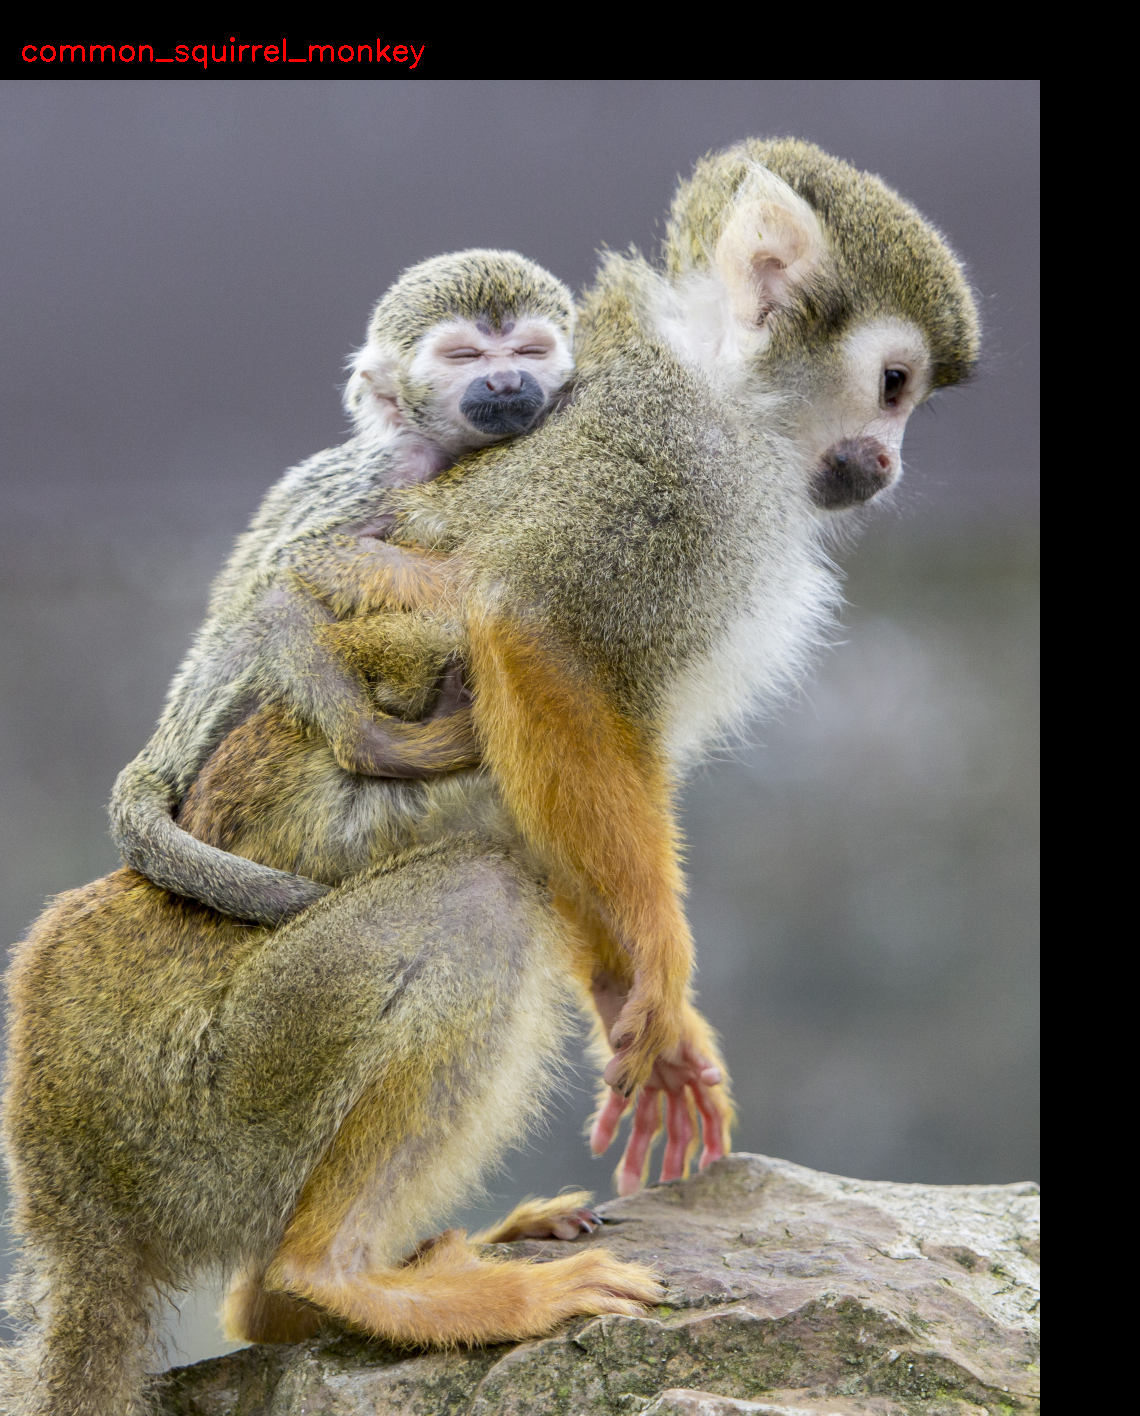

Class - nilgiri_langur


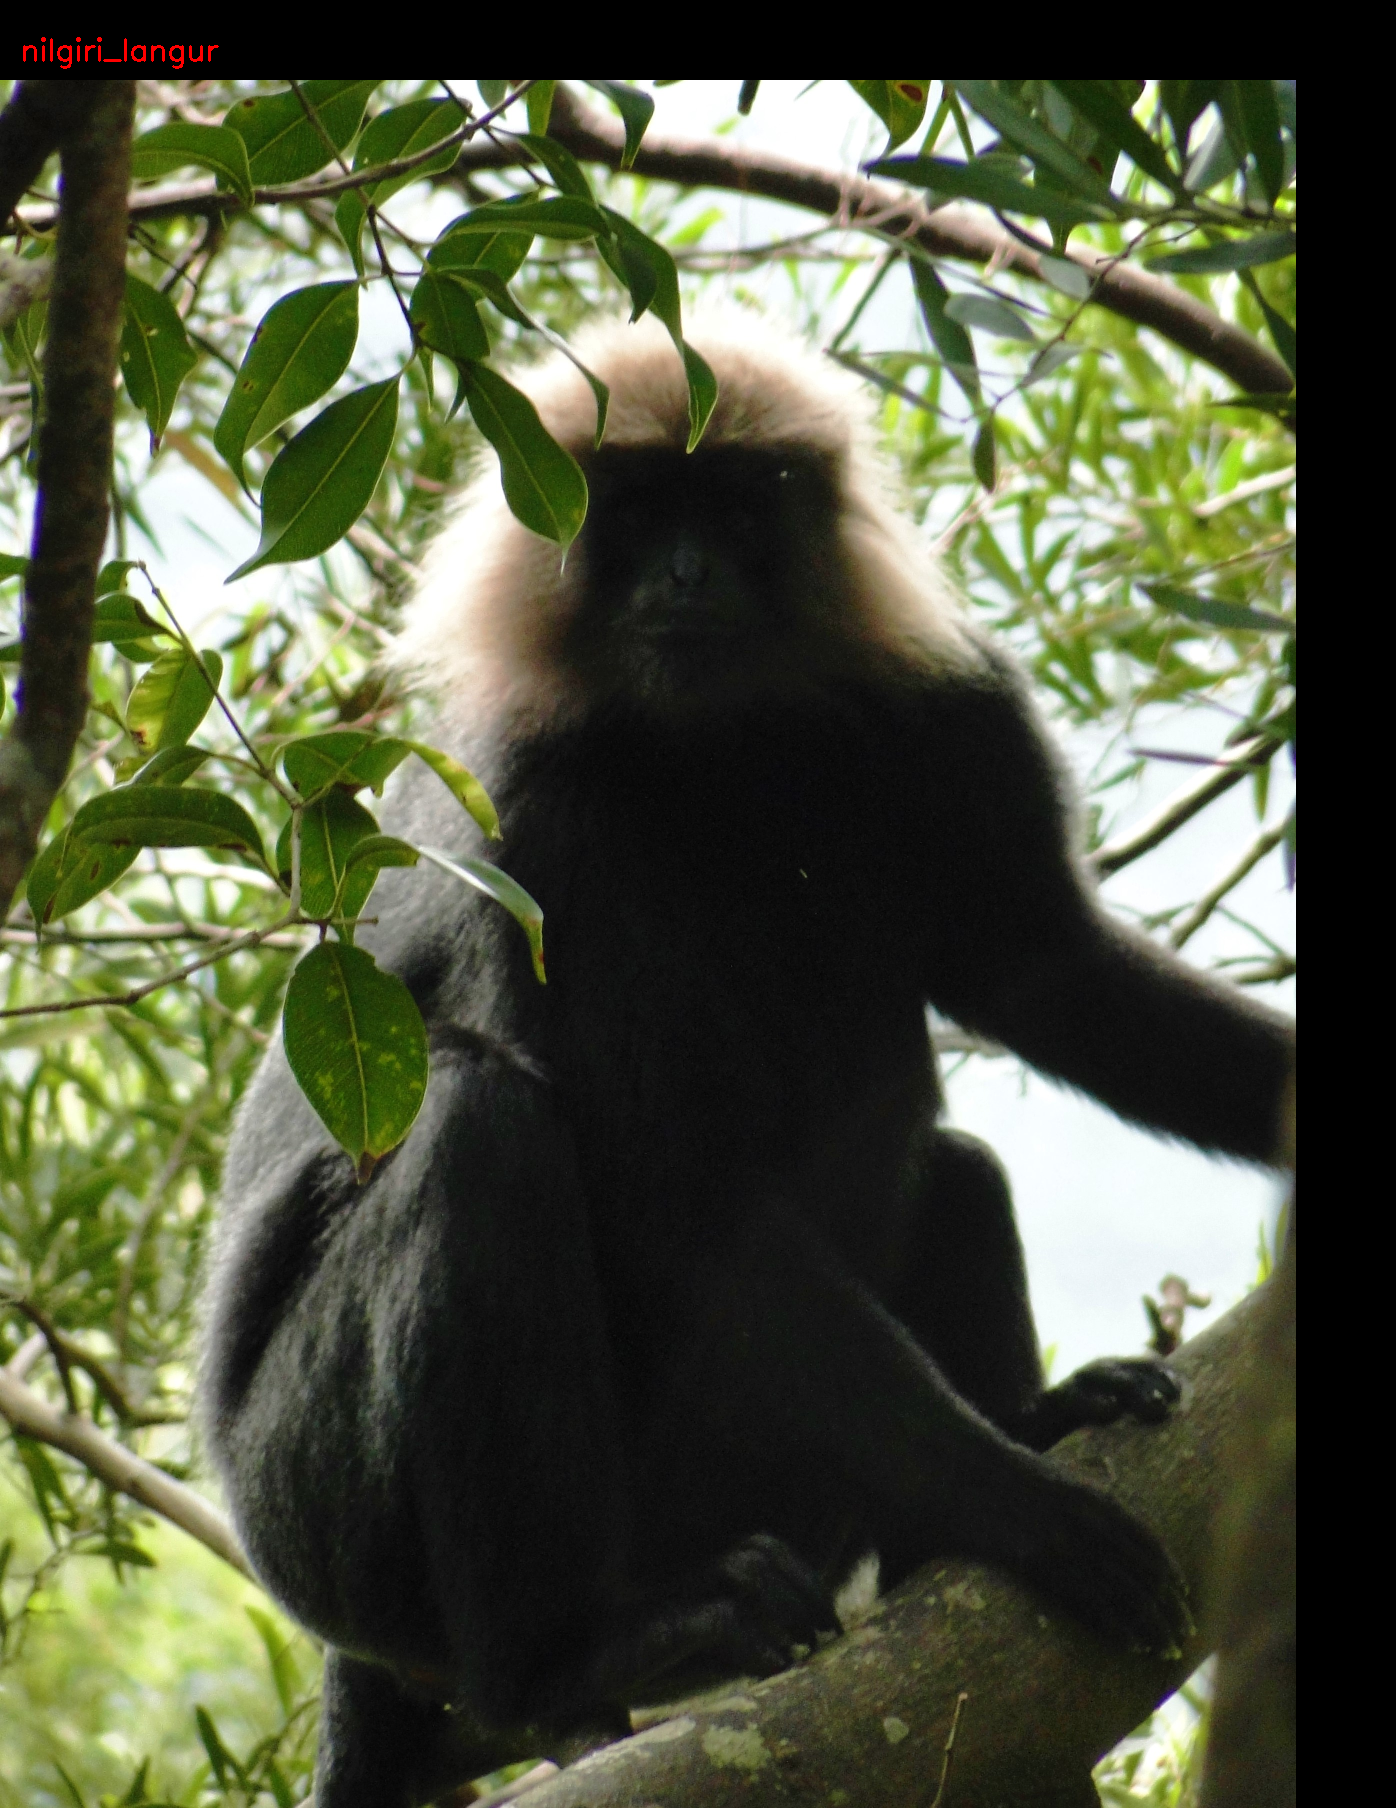

Class - bald_uakari


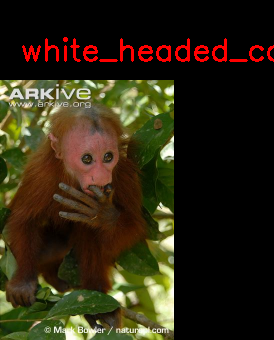

Class - silvery_marmoset


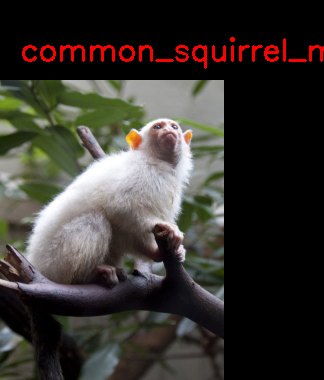

Class - silvery_marmoset


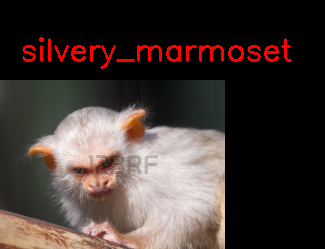

Class - common_squirrel_monkey


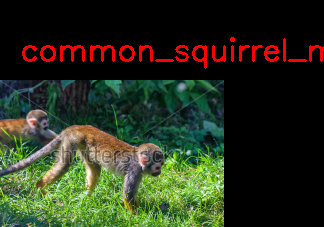

Class - white_headed_capuchin


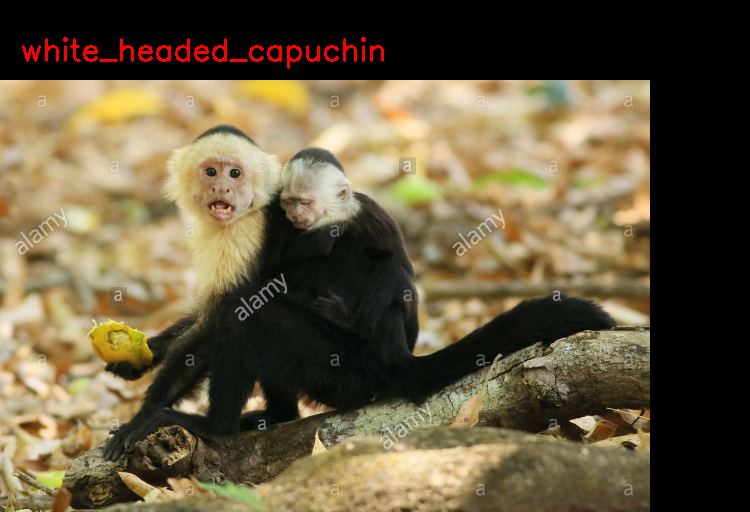

Class - japanese_macaque


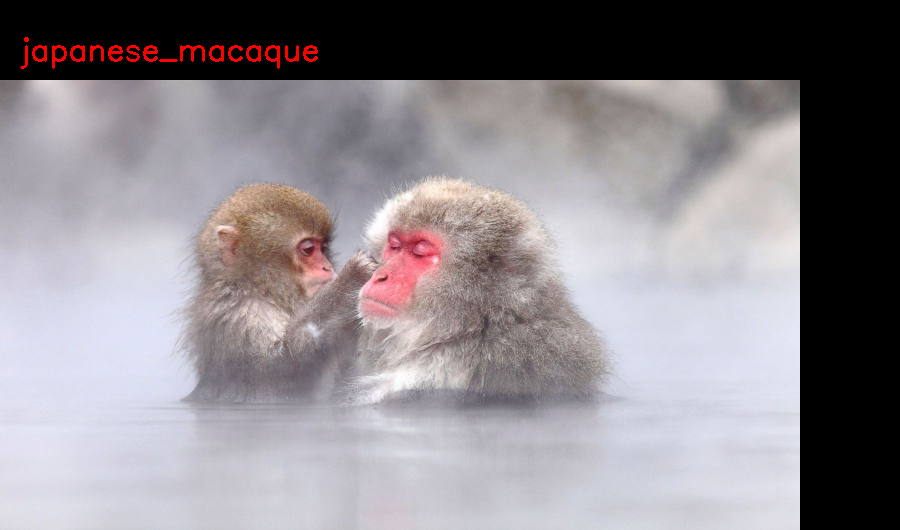

Class - nilgiri_langur


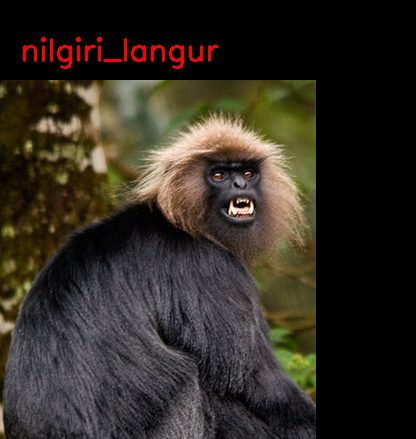

Class - white_headed_capuchin


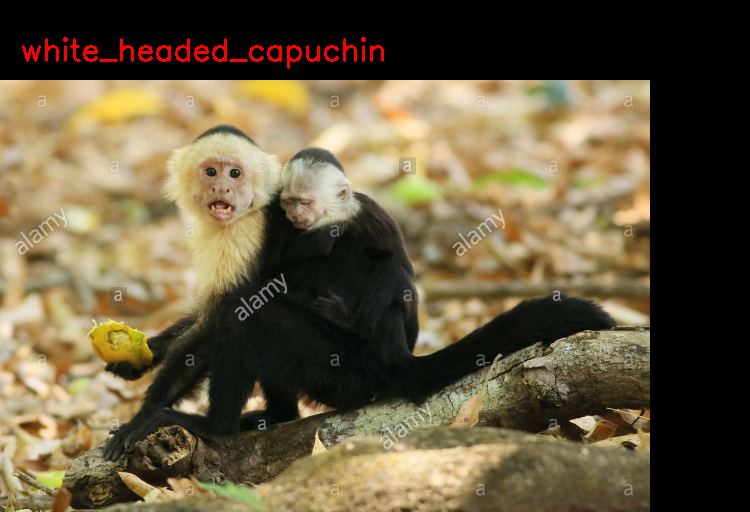

In [11]:
monkey_breeds_dict = {"[0]": "mantled_howler ", 
                      "[1]": "patas_monkey",
                      "[2]": "bald_uakari",
                      "[3]": "japanese_macaque",
                      "[4]": "pygmy_marmoset ",
                      "[5]": "white_headed_capuchin",
                      "[6]": "silvery_marmoset",
                      "[7]": "common_squirrel_monkey",
                      "[8]": "black_headed_night_monkey",
                      "[9]": "nilgiri_langur"}

monkey_breeds_dict_n = {"n0": "mantled_howler ", 
                      "n1": "patas_monkey",
                      "n2": "bald_uakari",
                      "n3": "japanese_macaque",
                      "n4": "pygmy_marmoset ",
                      "n5": "white_headed_capuchin",
                      "n6": "silvery_marmoset",
                      "n7": "common_squirrel_monkey",
                      "n8": "black_headed_night_monkey",
                      "n9": "nilgiri_langur"}

def draw_test(name, pred, im):
    monkey = monkey_breeds_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, monkey, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    # cv2.imshow(name, expanded_image)
    cv2_imshow(expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + monkey_breeds_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("./validation/validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

<br>

<br>

---

<br>

